# Noise Analysis
In thi notebook we test the effect of noisy inputs to the model.

In [1]:

%reload_ext autoreload
%autoreload 2

from torchvision import datasets
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pylab import *
import ast
import os
import sys
from statistics import mean
import torch


# import modules from JTAG model
# module_path = os.path.abspath(os.path.join('../../workspace/models/jets/code/')) # or the path to your source code
# sys.path.insert(0, module_path)
# import model as jet_tagger
# import jet_datamodule

# import modules from RN08 model
module_path = os.path.abspath(os.path.join('../../workspace/models/rn08/code/')) # or the path to your source code
sys.path.insert(0, module_path)
import rn08

# import modules from ECON model
module_path = os.path.abspath(os.path.join('../../workspace/models/econ/code/')) # or the path to your source code
sys.path.insert(0, module_path)
import q_autoencoder as econ



## Utility methods

In [2]:
def plot_2d_heatmap(values, 
                    title, 
                    min_max=(0, 1), 
                    x_label='Layers', 
                    y_label='Layers', 
                    scale_label='Value', 
                    cmap='Greens',
                    show_value=True):
    '''
    Method used to plot a 2D heatmap using Seaborn.
    '''
    # Set up the figure and axes
    plt.figure(figsize=(7, 6))

    # Create a heatmap using Seaborn
    sns.heatmap(values, 
                cmap=cmap, 
                annot=show_value, 
                fmt=".2f", 
                vmin=min_max[0], 
                vmax=min_max[1],
                cbar_kws={'label': scale_label})

    # Customize the plot
    plt.title(title)
    plt.xlabel(x_label)
    plt.ylabel(y_label)

    # Display the plot
    plt.show()

In [3]:
# search space
batch_sizes = [16, 32, 64, 128, 256, 512, 1024]
learning_rates = [0.1, 0.05, 0.025, 0.0125, 0.00625, 0.003125, 0.0015625]
precisions = [2, 3, 4, 5, 6, 7, 8, 9, 10, 11]

# ECON model (Autoencoder)
we focus our analysis on the encoder which will be deploy on an ASIC.

In [4]:
DATA_PATH = '/data/tbaldi/work/checkpoint/'
DATASET_DIR = '../../data/ECON/Elegun'
DATASET_FILE = 'nELinks5.npy'

size = 'baseline'

## EMD results

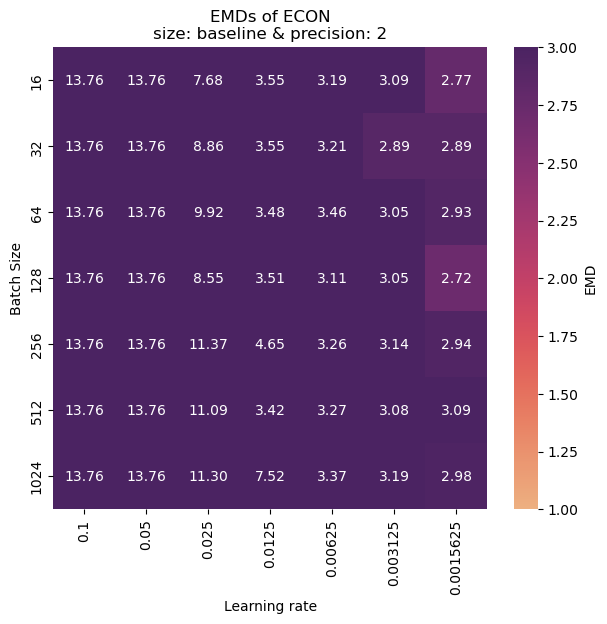

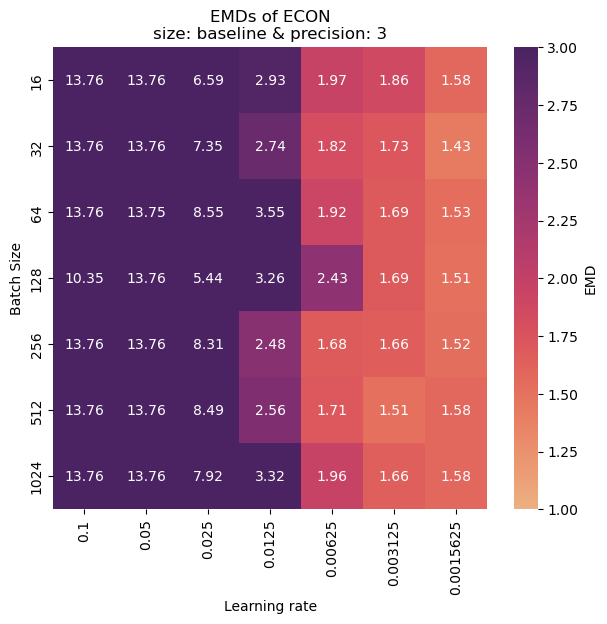

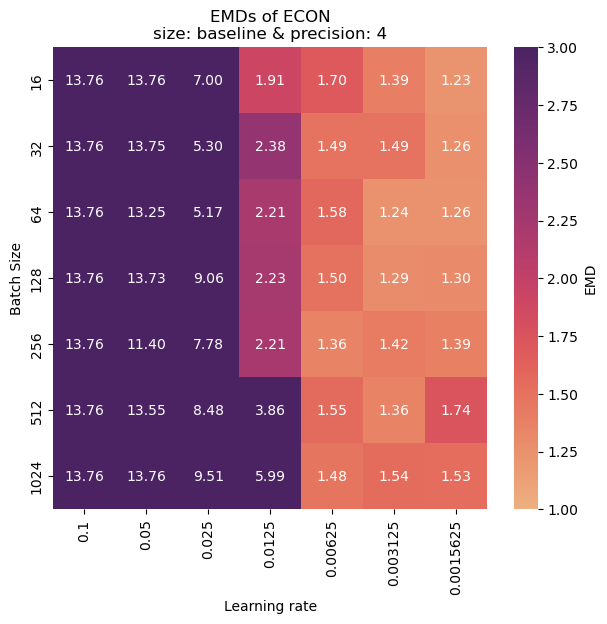

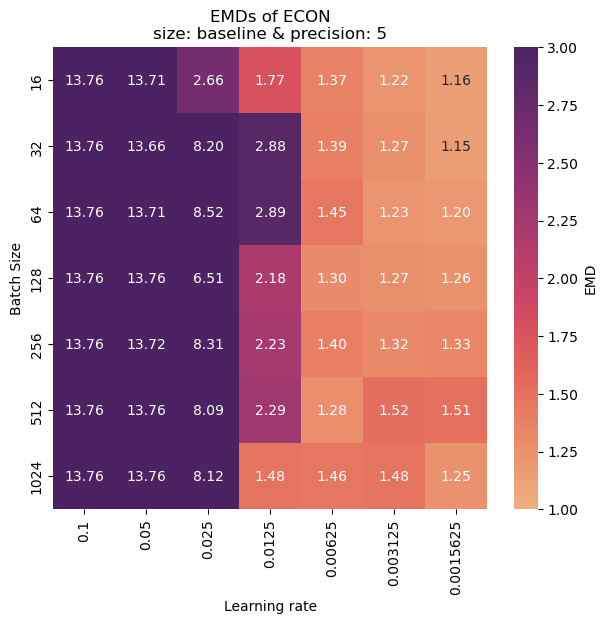

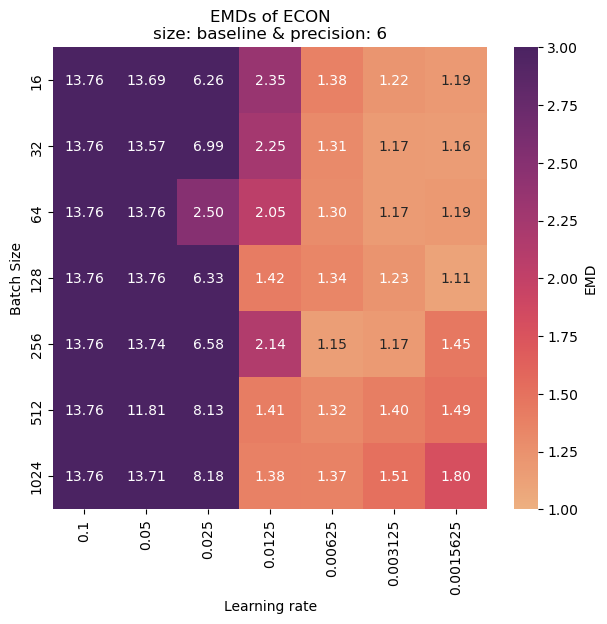

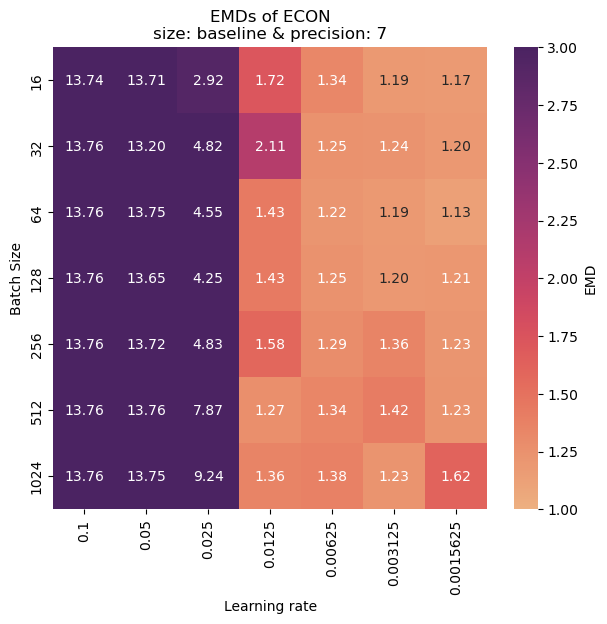

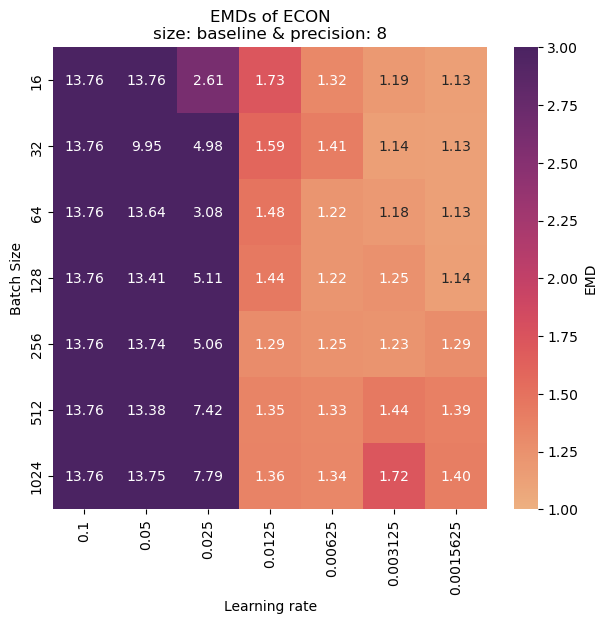

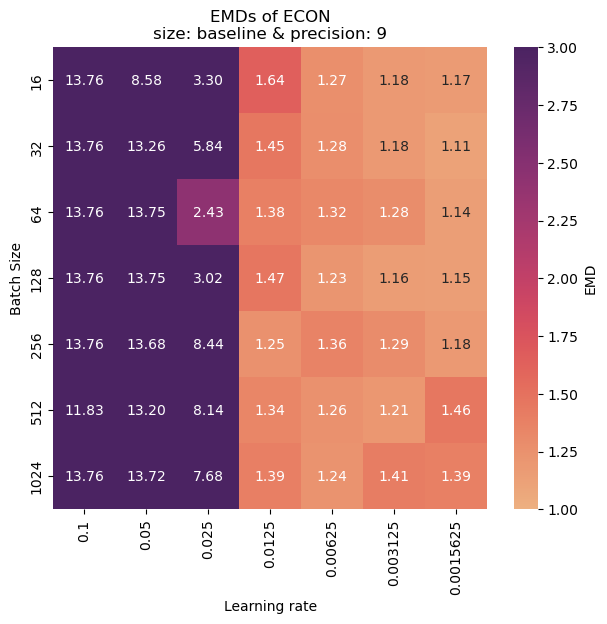

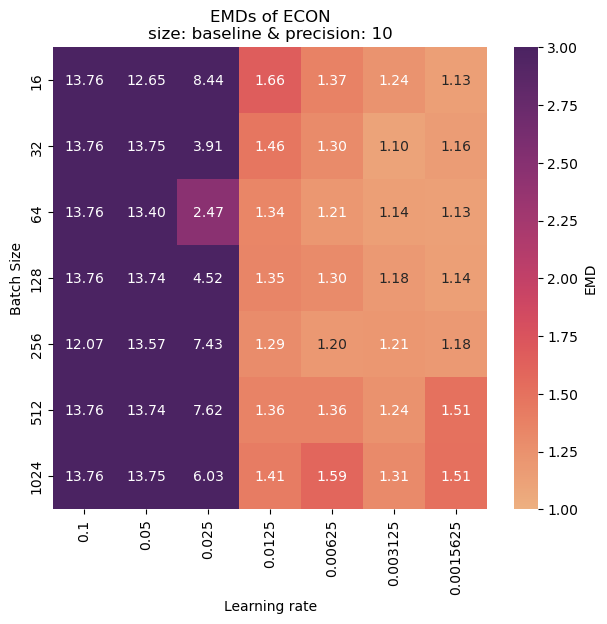

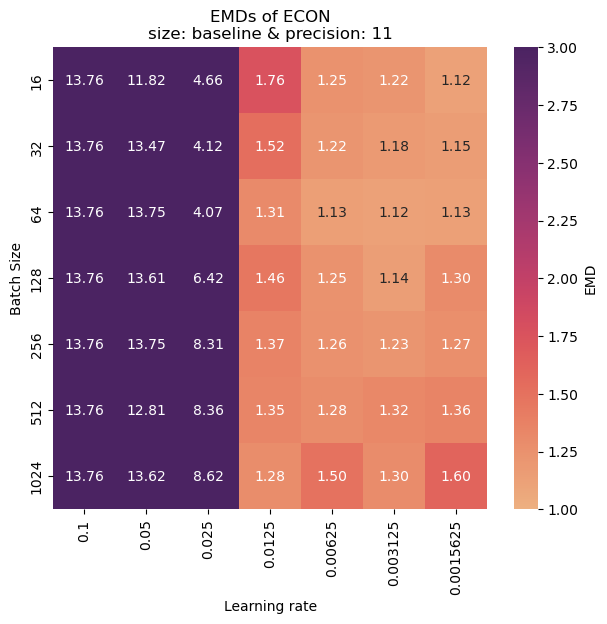

In [5]:
# plotting a heat map per layer
for p in precisions:
    EMD_matrix = np.zeros((len(batch_sizes), len(learning_rates)))
    for x, bs in enumerate(batch_sizes):
        for y, lr in enumerate(learning_rates):
            mean_EMD, _ = econ.get_model_index_and_relative_EMD(DATA_PATH, bs, lr, p, size)
            EMD_matrix[x, y] = mean_EMD
            
            
    EMD_matrix = pd.DataFrame(EMD_matrix, 
                              index=batch_sizes, 
                              columns=learning_rates)
    
    plot_2d_heatmap(EMD_matrix, 
                    f'EMDs of ECON\nsize: {size} & precision: {p}', 
                    (1, 3),
                    'Learning rate',
                    'Batch Size',
                    'EMD',
                    cmap='flare')

Let's remove high learning rates from next analysis:

In [6]:
learning_rates = [0.1, 0.05, 0.025, 0.0125, 0.00625, 0.003125, 0.0015625]

In [7]:
emd_distribution = []
for p in precisions:
    EMD_matrix = np.zeros((len(batch_sizes), len(learning_rates)))
    for x, bs in enumerate(batch_sizes):
        for y, lr in enumerate(learning_rates):
            mean_EMD, _ = econ.get_model_index_and_relative_EMD(DATA_PATH, bs, lr, p, size)
            EMD_matrix[x, y] = mean_EMD
            emd_distribution.append({
                'precision': p, 
                'EMD': mean_EMD,
                'batch_size': str(bs),
                'learning_rate': str(lr),
            })

In [8]:
emd_distribution_df = pd.DataFrame(emd_distribution)
emd_distribution_df = emd_distribution_df.sort_values(by='EMD', ascending=True)
emd_distribution_df.head(10)

precision       EMD batch_size learning_rate
404         10  1.104643         32      0.003125
223          6  1.105781        128     0.0015625
356          9  1.114145         32     0.0015625
447         11  1.120972         16     0.0015625
460         11  1.123161         64      0.003125
412         10  1.126236         64     0.0015625
307          8  1.127017         32     0.0015625
461         11  1.127617         64     0.0015625
314          8  1.127975         64     0.0015625
265          7  1.132471         64     0.0015625

## Scientific Benchmark

In [9]:
precisions = [2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
noise_type = 'gaussian'

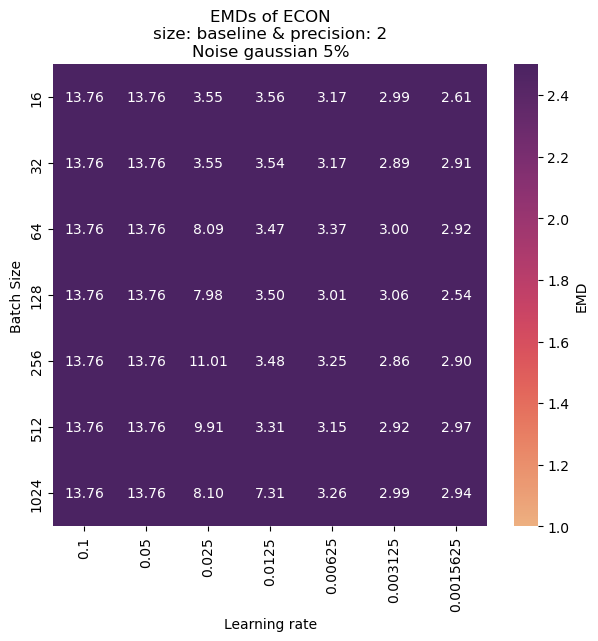

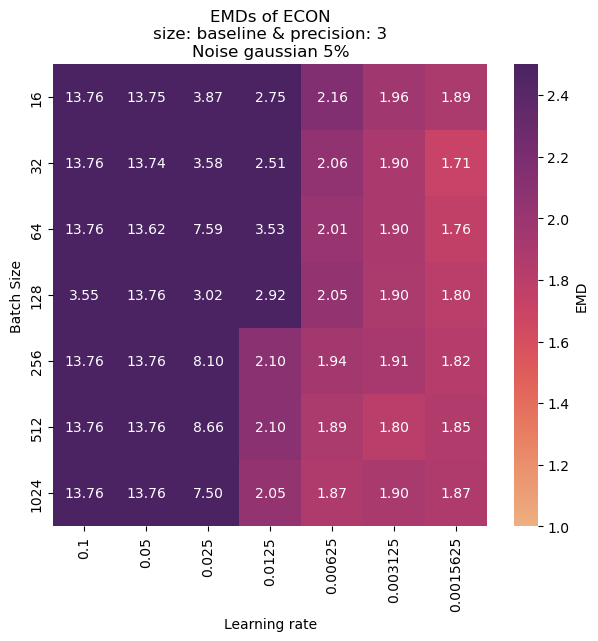

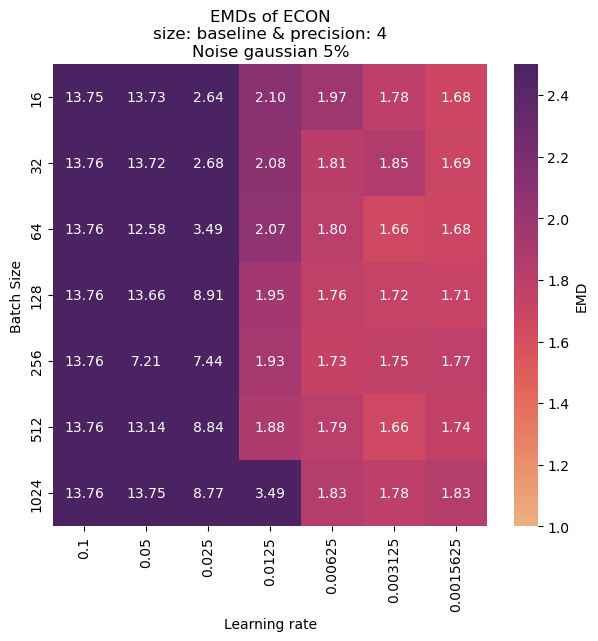

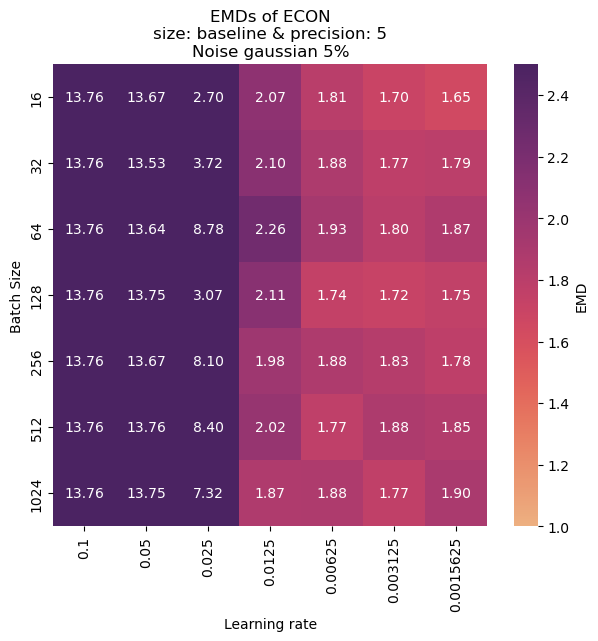

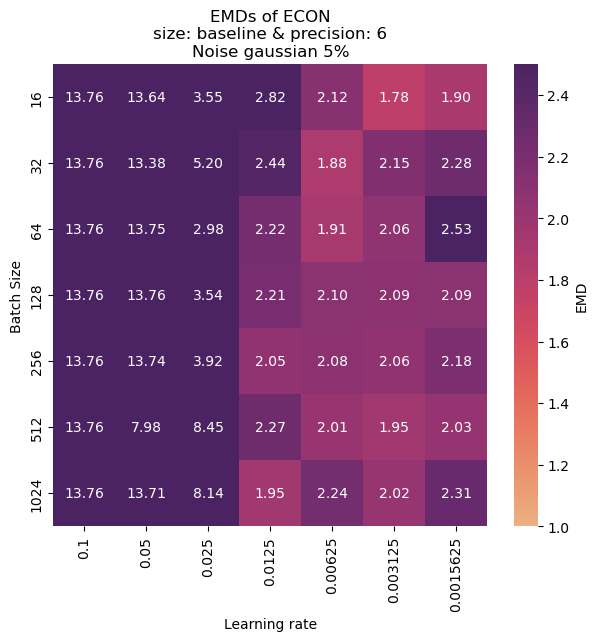

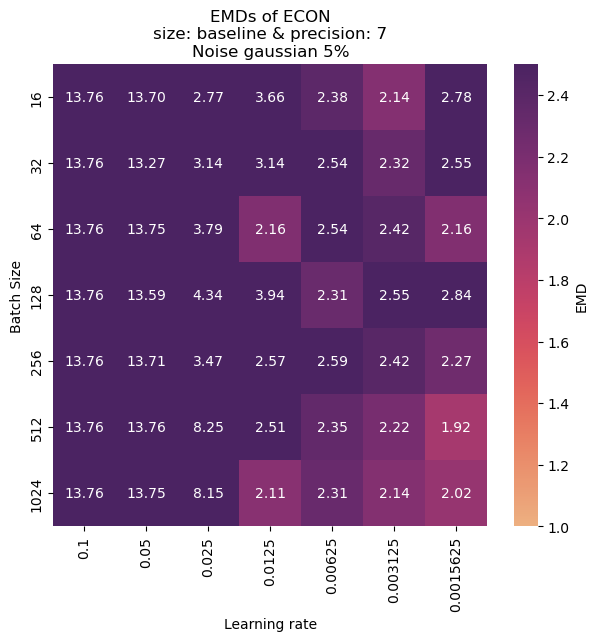

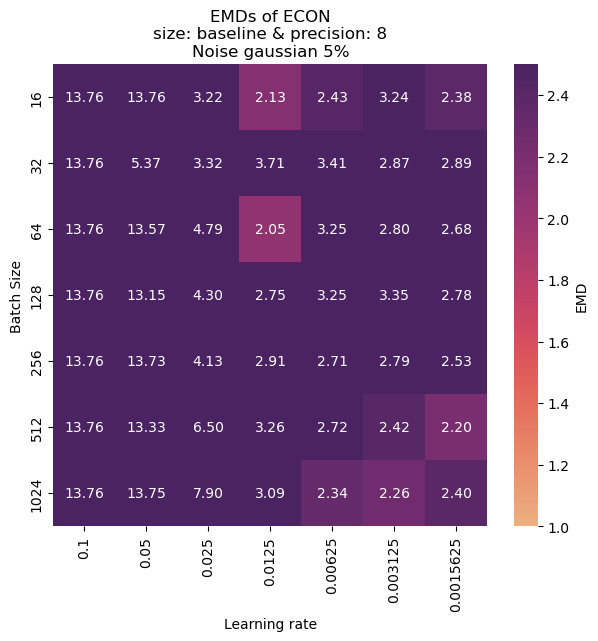

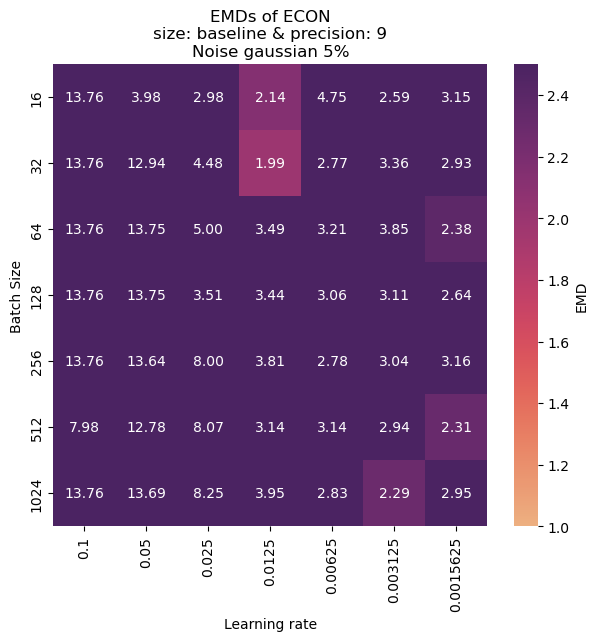

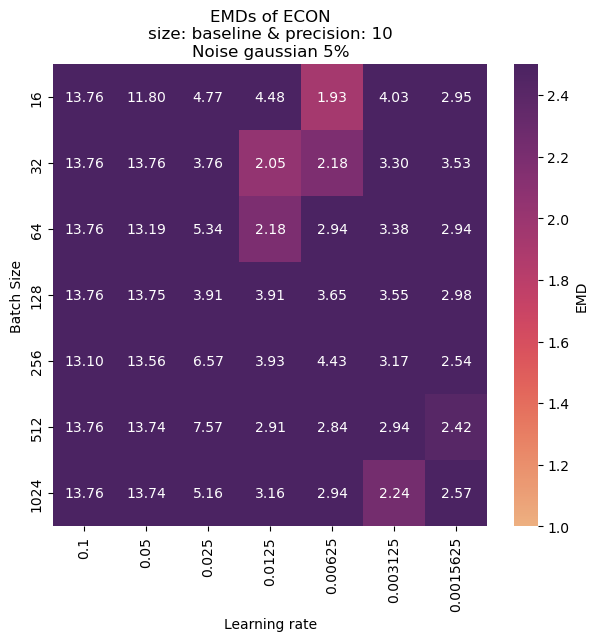

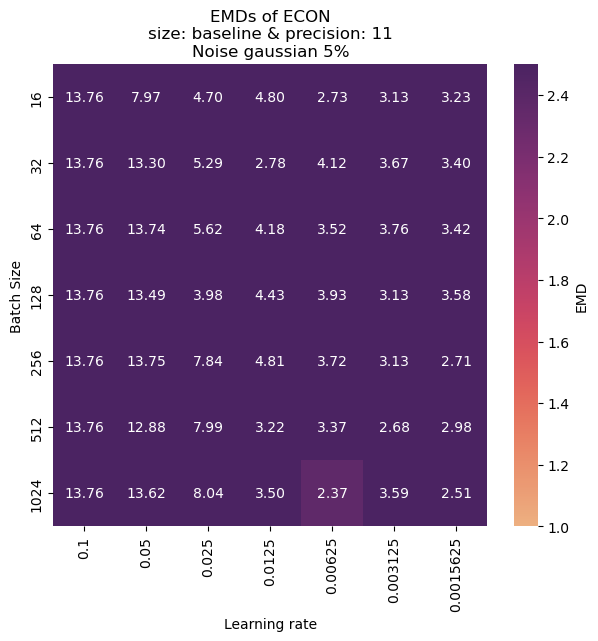

In [10]:
emd_distribution = []
for p in precisions:
    EMD_matrix = np.zeros((len(batch_sizes), len(learning_rates)))
    for x, bs in enumerate(batch_sizes):
        for y, lr in enumerate(learning_rates):
            # get teh noise values
            noise_emd_5 = econ.get_emd_with_noise(DATA_PATH, bs, lr, p, size, noise_type, 5)
            noise_emd_10 = econ.get_emd_with_noise(DATA_PATH, bs, lr, p, size, noise_type, 10)
            noise_emd_15 = econ.get_emd_with_noise(DATA_PATH, bs, lr, p, size, noise_type, 15)
            noise_emd_20 = econ.get_emd_with_noise(DATA_PATH, bs, lr, p, size, noise_type, 20)
            original_emd, _ = econ.get_model_index_and_relative_EMD(DATA_PATH, bs, lr, p, size)
            
            # build the matrix for the heatmap
            EMD_matrix[x, y] = noise_emd_5
            
            # store the values for the plots
            emd_distribution.append({
                'precision': p, 
                'emd': original_emd,
                # 'noise 5%': (noise_emd_5 - original_emd) * 100 / original_emd,
                # 'noise 10%': (noise_emd_10 - original_emd) * 100 / original_emd,
                # 'noise 15%': (noise_emd_15 - original_emd) * 100 / original_emd,
                # 'noise 20%': (noise_emd_20 - original_emd) * 100 / original_emd,
                'noise 5%': noise_emd_5,
                'noise 10%': noise_emd_10,
                'noise 15%': noise_emd_15,
                'noise 20%': noise_emd_20,
                'batch_size': str(bs),
                'learning_rate': str(lr),
                'precision': p,
            })
            
    # heat map of the EMD with noise as input per precision
    EMD_matrix = pd.DataFrame(EMD_matrix, 
                              index=batch_sizes, 
                              columns=learning_rates)
    
    plot_2d_heatmap(EMD_matrix, 
                    f'EMDs of ECON\nsize: {size} & precision: {p}\n' \
                    f'Noise {noise_type} 5%', 
                    (1, 2.5),
                    'Learning rate',
                    'Batch Size',
                    'EMD',
                    cmap='flare')
        

In [11]:
emd_distribution_df = pd.DataFrame(emd_distribution)
# export the CSV
emd_distribution_df.to_csv("./results/econ/noise.csv", index=False)

We want to plot the heatmap based on the precision, because the batch size is not correlated with the EMD and the noise.

--------------------------------------------------------------------------------


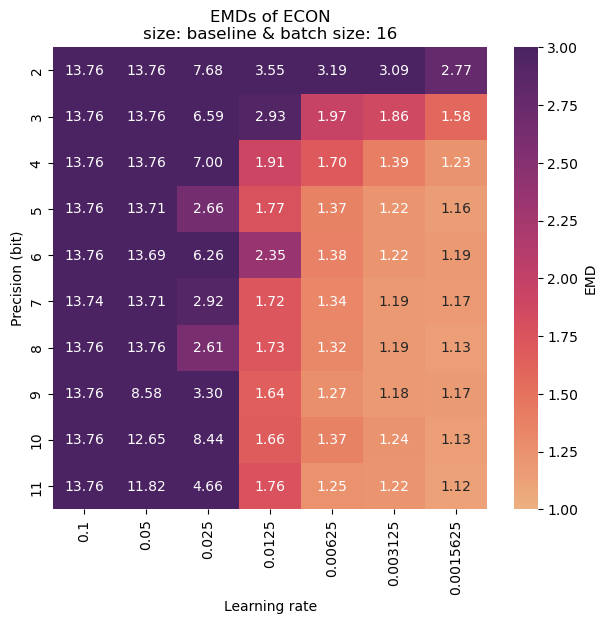

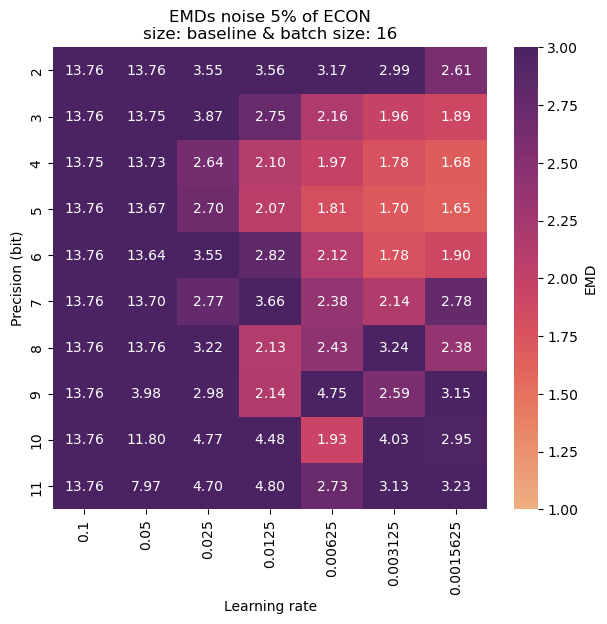

--------------------------------------------------------------------------------


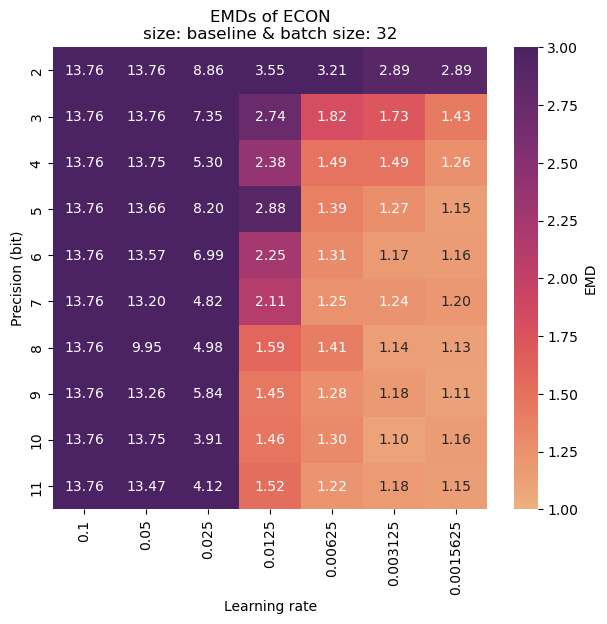

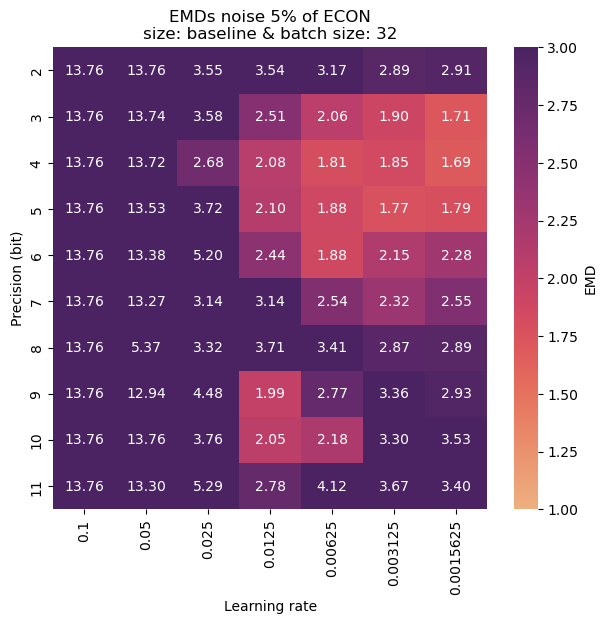

--------------------------------------------------------------------------------


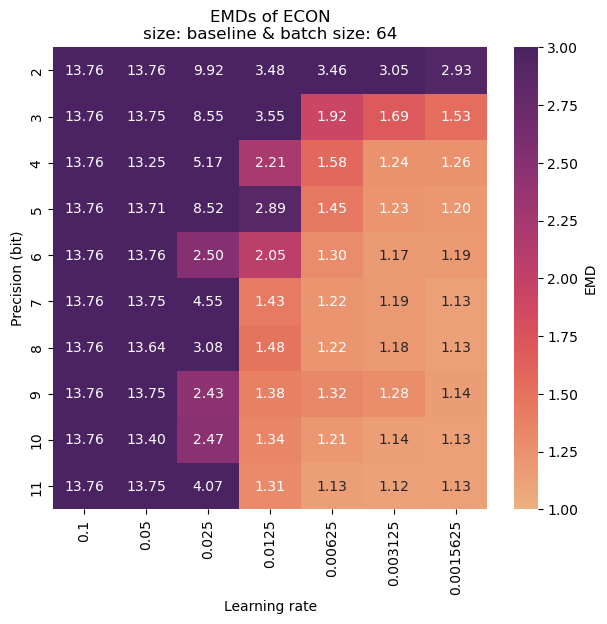

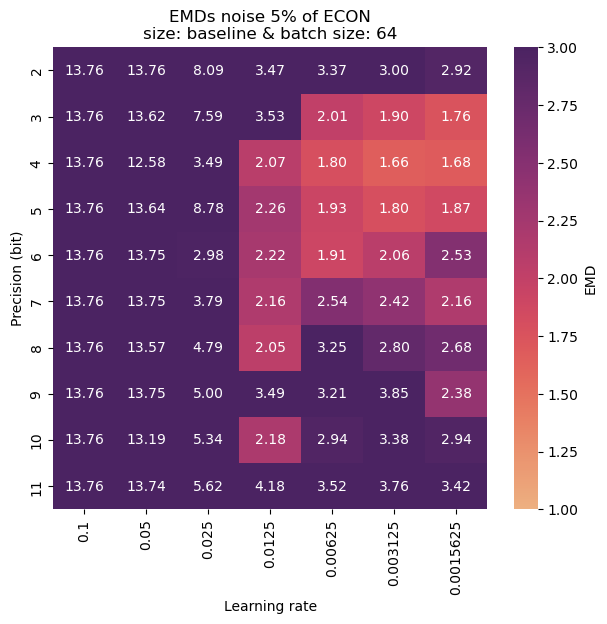

--------------------------------------------------------------------------------


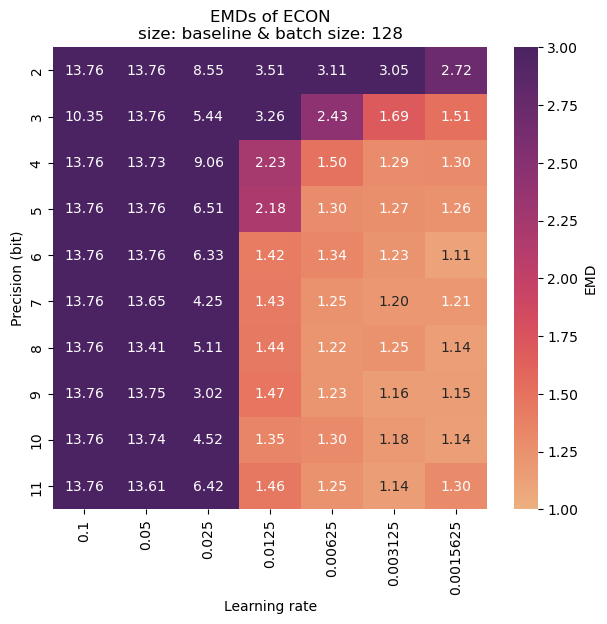

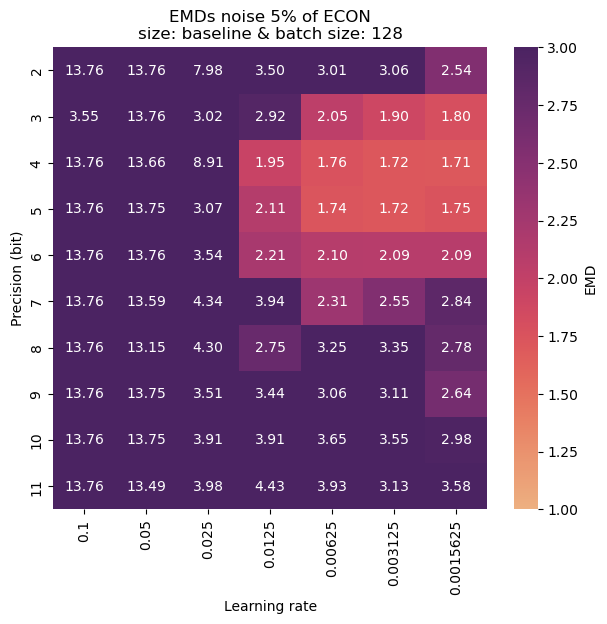

--------------------------------------------------------------------------------


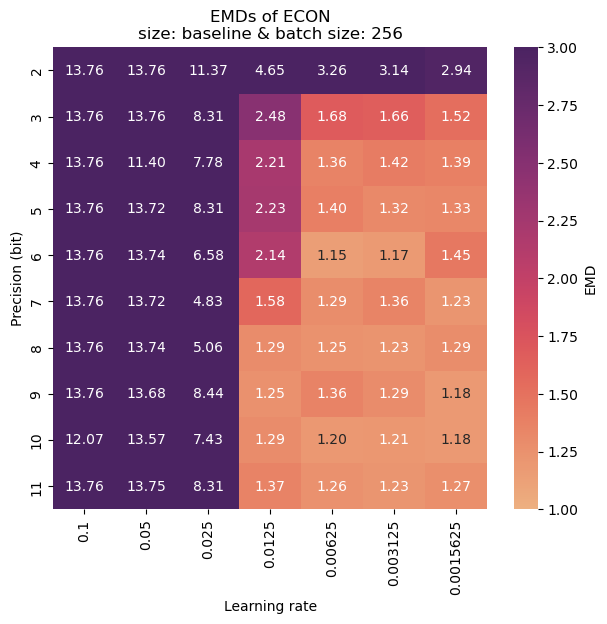

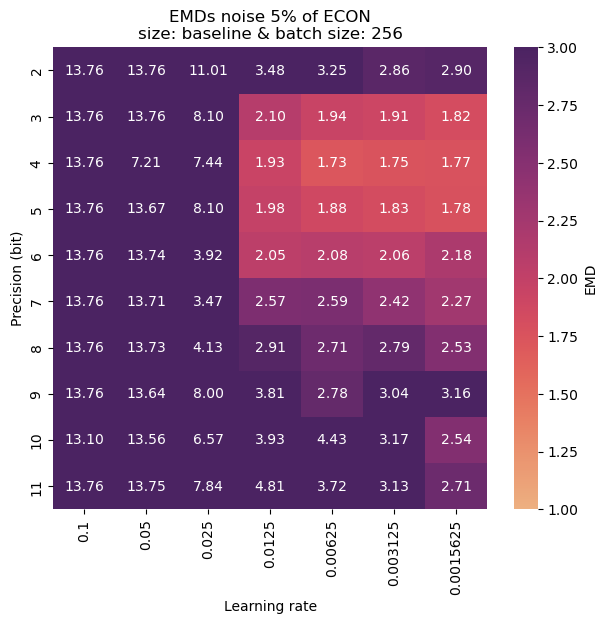

--------------------------------------------------------------------------------


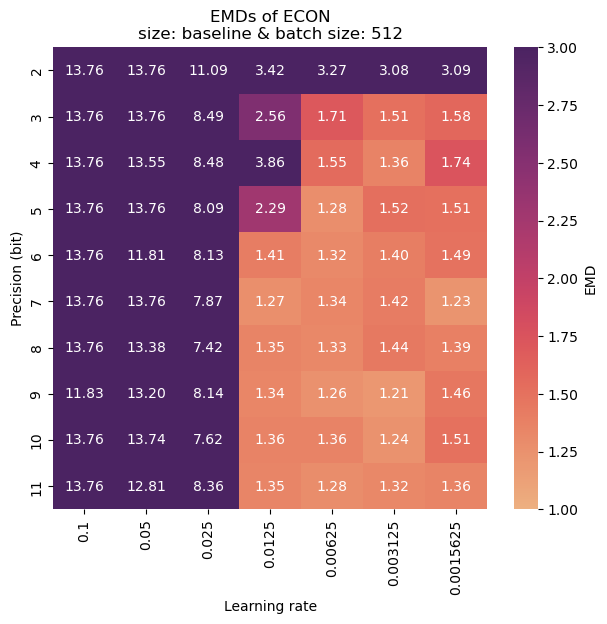

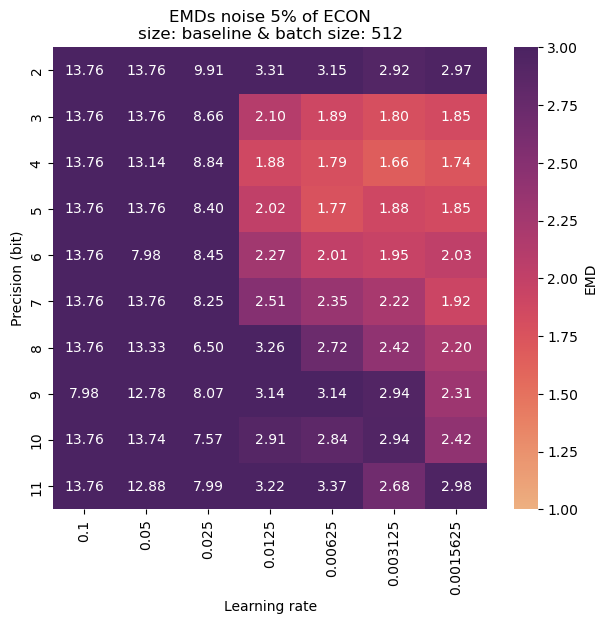

--------------------------------------------------------------------------------


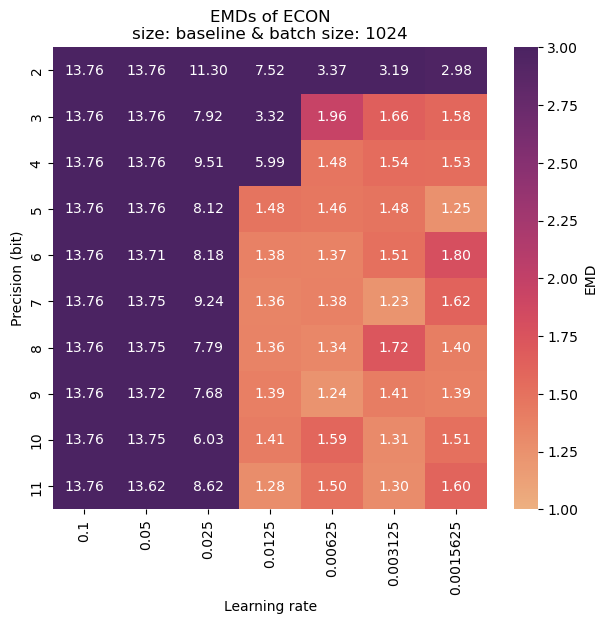

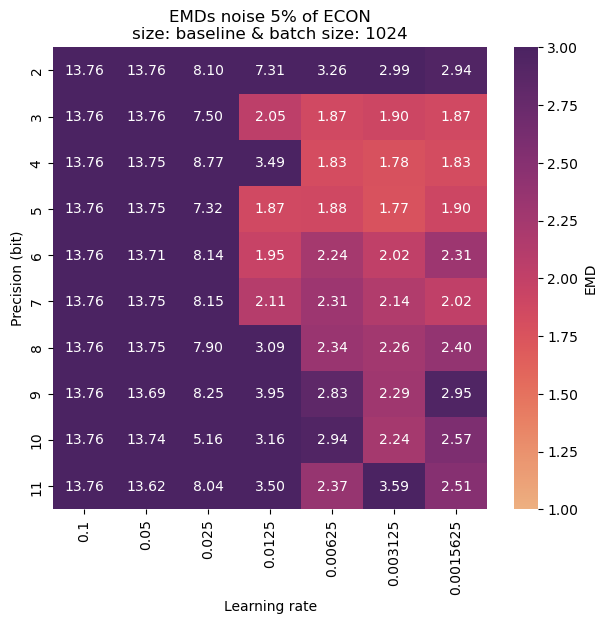

In [12]:

for bs in batch_sizes:
    matrix = np.zeros((len(precisions), len(learning_rates)))
    noise_matrix = np.zeros((len(precisions), len(learning_rates)))
    for y, lr in enumerate(learning_rates):
        for x, p in enumerate(precisions):
            
            # get the performances with and without noise
            mean_emd, _ = econ.get_model_index_and_relative_EMD(DATA_PATH, bs, lr, p, size)
            noise_emd_5 = econ.get_emd_with_noise(DATA_PATH, bs, lr, p, size, noise_type, 5)
            
            # build the heatmap matrix
            matrix[x, y] = mean_emd
            noise_matrix[x, y] = noise_emd_5

            
    # plot the heatmaps per precision
    matrix = pd.DataFrame(matrix, 
                          index=precisions, 
                          columns=learning_rates)
    noise_matrix = pd.DataFrame(noise_matrix, 
                          index=precisions, 
                          columns=learning_rates)
    print(80*'-')
    plot_2d_heatmap(matrix, 
                    f'EMDs of ECON\nsize: {size} & batch size: {bs}', 
                    (1, 3),
                    'Learning rate',
                    'Precision (bit)',
                    'EMD',
                    cmap='flare')
    
    plot_2d_heatmap(noise_matrix, 
                    f'EMDs noise 5% of ECON\nsize: {size} & batch size: {bs}', 
                    (1, 3),
                    'Learning rate',
                    'Precision (bit)',
                    'EMD',
                    cmap='flare')
    

In [13]:
top_noise_df = emd_distribution_df.sort_values(by='emd', ascending=True)
top_noise_df.head(10)

precision       emd  noise 5%  noise 10%  noise 15%  noise 20%  \
404         10  1.104643  3.295514   3.608166   3.627738   3.625013   
223          6  1.105781  2.092937   3.006155   3.534956   3.847934   
356          9  1.114145  2.930733   3.458393   3.635916   3.713881   
447         11  1.120972  3.225034   3.688270   3.804184   3.845747   
460         11  1.123161  3.758025   3.925178   3.953398   3.956901   
412         10  1.126236  2.939933   3.599533   3.833584   3.948925   
307          8  1.127017  2.892940   3.398102   3.557063   3.627581   
461         11  1.127617  3.419863   3.819421   3.957435   4.023776   
314          8  1.127975  2.684867   3.474687   3.793486   3.931022   
265          7  1.132471  2.158104   3.113376   3.681315   4.003596   

    batch_size learning_rate  
404         32      0.003125  
223        128     0.0015625  
356         32     0.0015625  
447         16     0.0015625  
460         64      0.003125  
412         64     0.0015625  
307         32     0.0015625  
461         64     0.0015625  
314         64     0.0015625  
265         64     0.0015625

# RN08 (TinyResNet)
Computer vision tasks trained on CIFAR10

In [14]:
# search space
batch_sizes = [16, 32, 64, 128, 256, 512, 1024]
learning_rates = [0.1, 0.05, 0.025, 0.0125, 0.00625, 0.003125, 0.0015625]
precisions = [2, 3, 4, 5, 6, 7, 8, 9, 10, 11]

In [15]:
DATA_PATH="/data/tbaldi/work/checkpoint/"   
DATASET_DIR = "/data/tbaldi/work/loss_landscape_taxonomy/data/RN08/"

## Accuracy results

File not found! (/data/tbaldi/work/checkpoint/bs32_lr0.05/RN08_2b/accuracy_1.txt)
File not found! (/data/tbaldi/work/checkpoint/bs32_lr0.00625/RN08_2b/accuracy_1.txt)
File not found! (/data/tbaldi/work/checkpoint/bs64_lr0.025/RN08_2b/accuracy_1.txt)
File not found! (/data/tbaldi/work/checkpoint/bs64_lr0.0125/RN08_2b/accuracy_1.txt)
File not found! (/data/tbaldi/work/checkpoint/bs128_lr0.05/RN08_2b/accuracy_1.txt)
File not found! (/data/tbaldi/work/checkpoint/bs128_lr0.00625/RN08_2b/accuracy_1.txt)
File not found! (/data/tbaldi/work/checkpoint/bs256_lr0.003125/RN08_2b/accuracy_1.txt)
File not found! (/data/tbaldi/work/checkpoint/bs512_lr0.0015625/RN08_2b/accuracy_1.txt)
File not found! (/data/tbaldi/work/checkpoint/bs1024_lr0.003125/RN08_2b/accuracy_1.txt)
File not found! (/data/tbaldi/work/checkpoint/bs1024_lr0.0015625/RN08_2b/accuracy_1.txt)


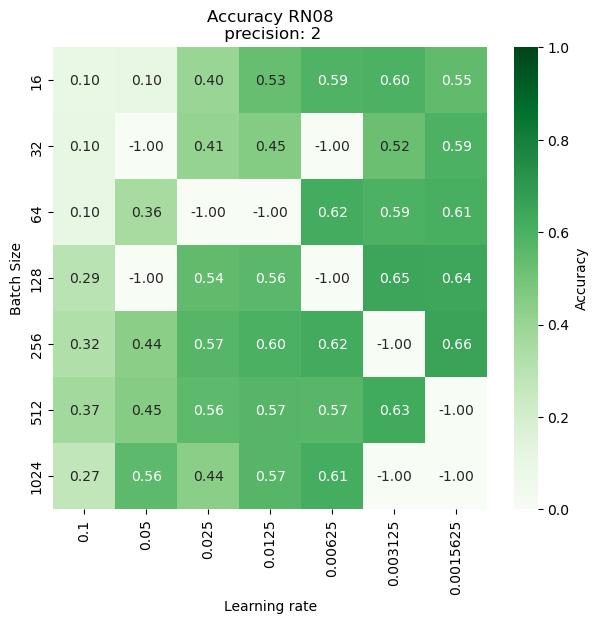

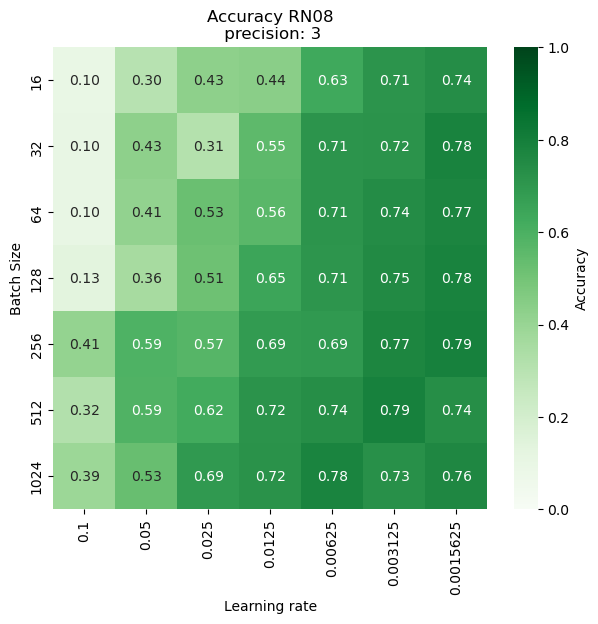

File not found! (/data/tbaldi/work/checkpoint/bs1024_lr0.00625/RN08_4b/accuracy_1.txt)


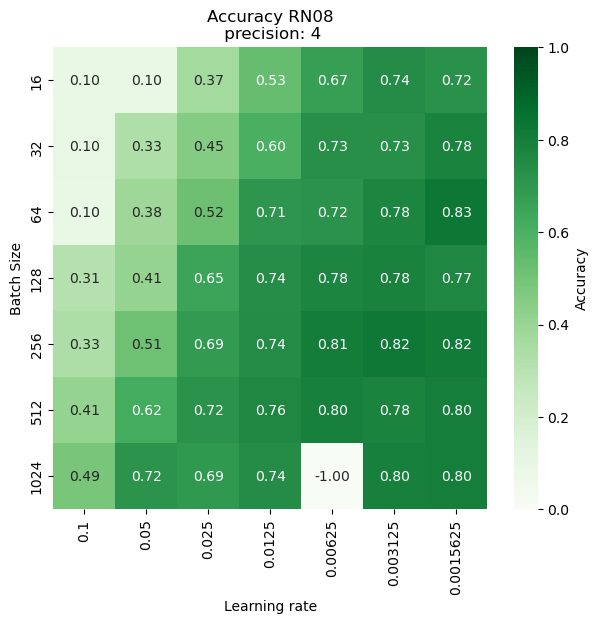

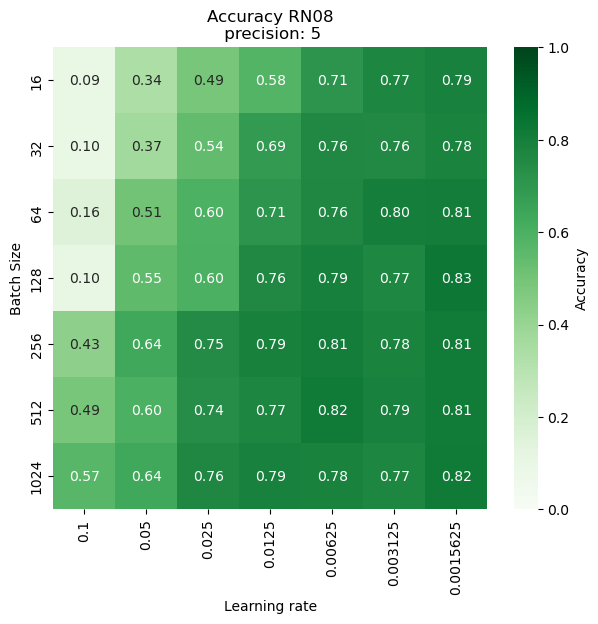

File not found! (/data/tbaldi/work/checkpoint/bs1024_lr0.00625/RN08_6b/accuracy_1.txt)


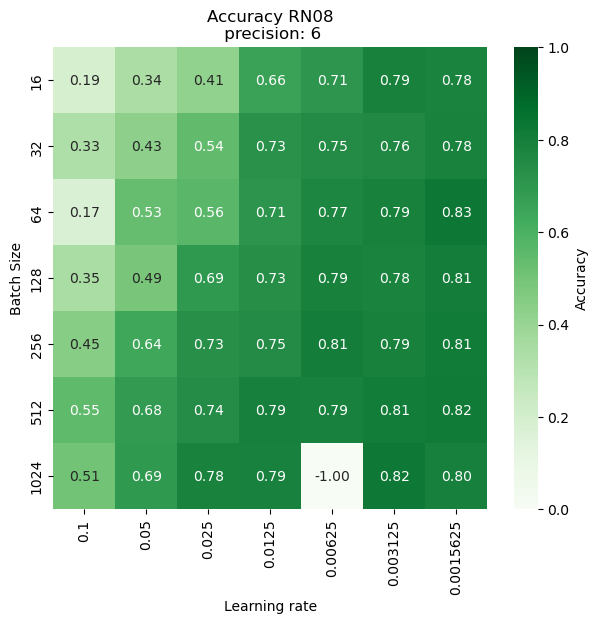

File not found! (/data/tbaldi/work/checkpoint/bs1024_lr0.00625/RN08_7b/accuracy_1.txt)


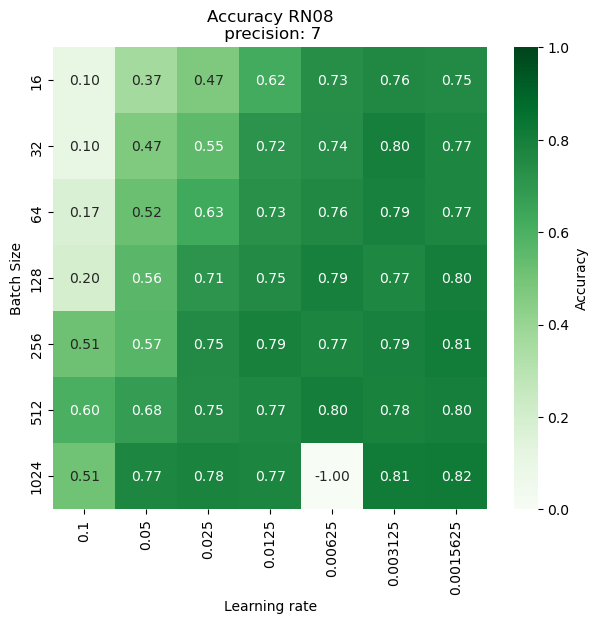

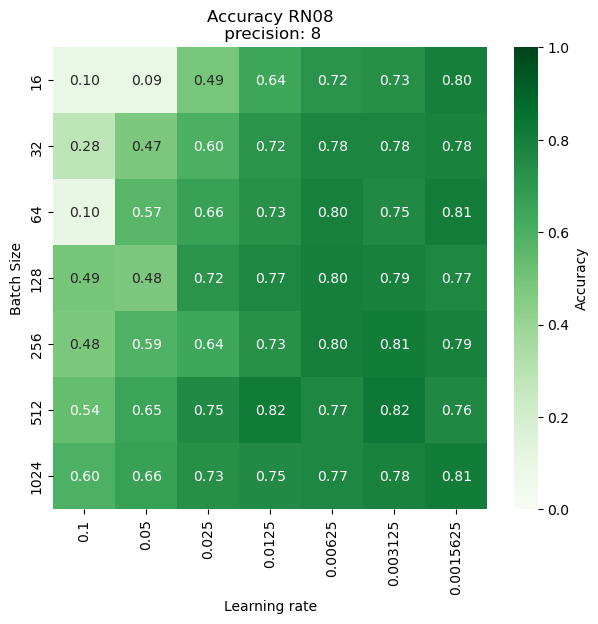

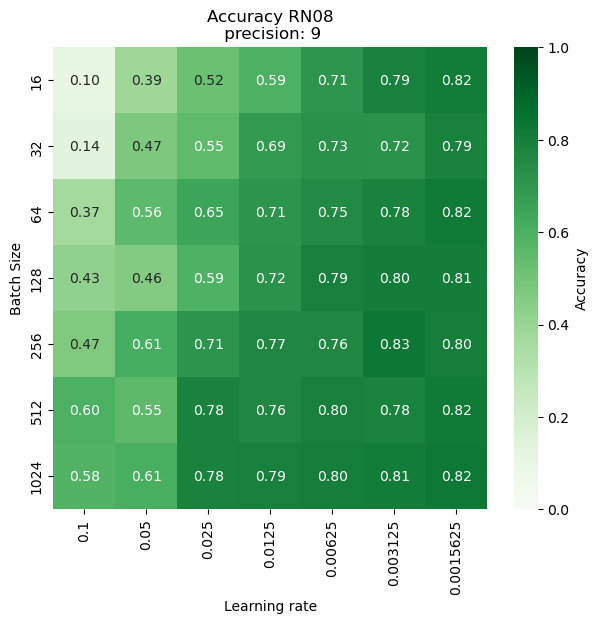

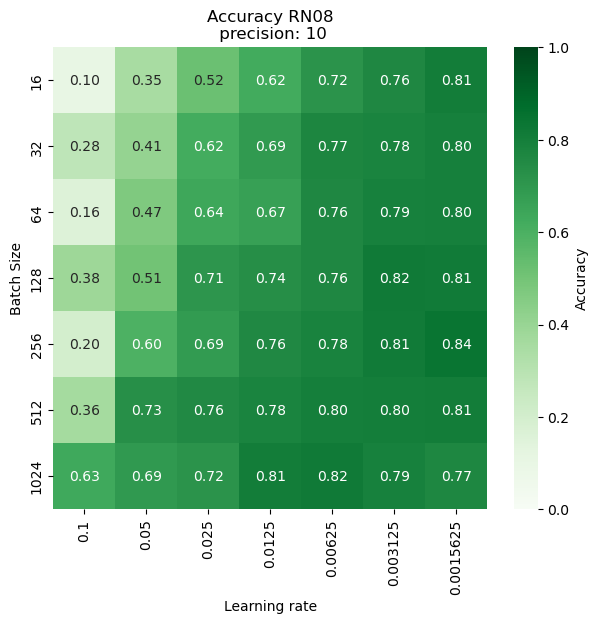

File not found! (/data/tbaldi/work/checkpoint/bs1024_lr0.00625/RN08_11b/accuracy_1.txt)


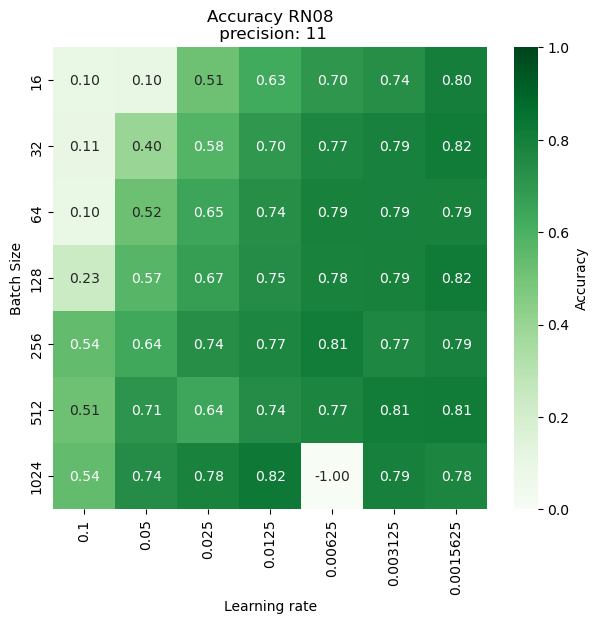

In [16]:
# plotting a heat map per layer
for p in precisions:
    matrix = np.zeros((len(batch_sizes), len(learning_rates)))
    for x, bs in enumerate(batch_sizes):
        for y, lr in enumerate(learning_rates):
            acc = rn08.get_accuracy(DATA_PATH, bs, lr, p)
            matrix[x, y] = acc
            
            
    matrix = pd.DataFrame(matrix, 
                          index=batch_sizes, 
                          columns=learning_rates)
    
    plot_2d_heatmap(matrix, 
                    f'Accuracy RN08\n precision: {p}', 
                    (0, 1),
                    'Learning rate',
                    'Batch Size',
                    'Accuracy',
                    cmap='Greens')

## Scientific Benchmark

In [17]:

noise_type = "pixelate"
precisions = [2, 3, 4, 5, 6, 7, 8, 9, 10, 11]

File not found! (/data/tbaldi/work/checkpoint/bs32_lr0.05/RN08_2b/accuracy_1.txt)
/data/tbaldi/work/checkpoint/bs32_lr0.05/RN08_2b/accuracy_pixelate.txt not found!
File not found! (/data/tbaldi/work/checkpoint/bs32_lr0.00625/RN08_2b/accuracy_1.txt)
/data/tbaldi/work/checkpoint/bs32_lr0.00625/RN08_2b/accuracy_pixelate.txt not found!
File not found! (/data/tbaldi/work/checkpoint/bs64_lr0.025/RN08_2b/accuracy_1.txt)
/data/tbaldi/work/checkpoint/bs64_lr0.025/RN08_2b/accuracy_pixelate.txt not found!
File not found! (/data/tbaldi/work/checkpoint/bs64_lr0.0125/RN08_2b/accuracy_1.txt)
/data/tbaldi/work/checkpoint/bs64_lr0.0125/RN08_2b/accuracy_pixelate.txt not found!
File not found! (/data/tbaldi/work/checkpoint/bs128_lr0.05/RN08_2b/accuracy_1.txt)
/data/tbaldi/work/checkpoint/bs128_lr0.05/RN08_2b/accuracy_pixelate.txt not found!
File not found! (/data/tbaldi/work/checkpoint/bs128_lr0.00625/RN08_2b/accuracy_1.txt)
/data/tbaldi/work/checkpoint/bs128_lr0.00625/RN08_2b/accuracy_pixelate.txt not f

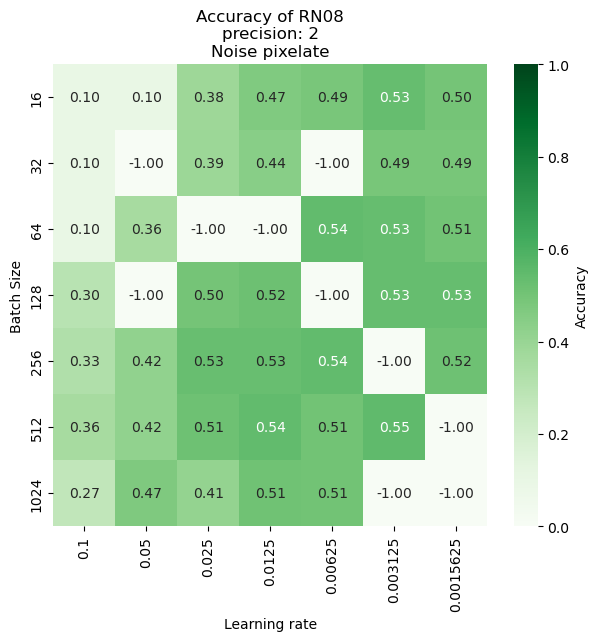

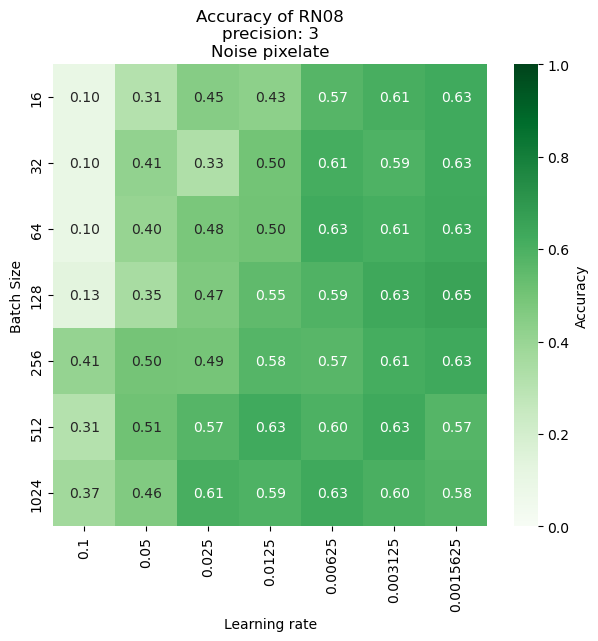

File not found! (/data/tbaldi/work/checkpoint/bs1024_lr0.00625/RN08_4b/accuracy_1.txt)
/data/tbaldi/work/checkpoint/bs1024_lr0.00625/RN08_4b/accuracy_pixelate.txt not found!


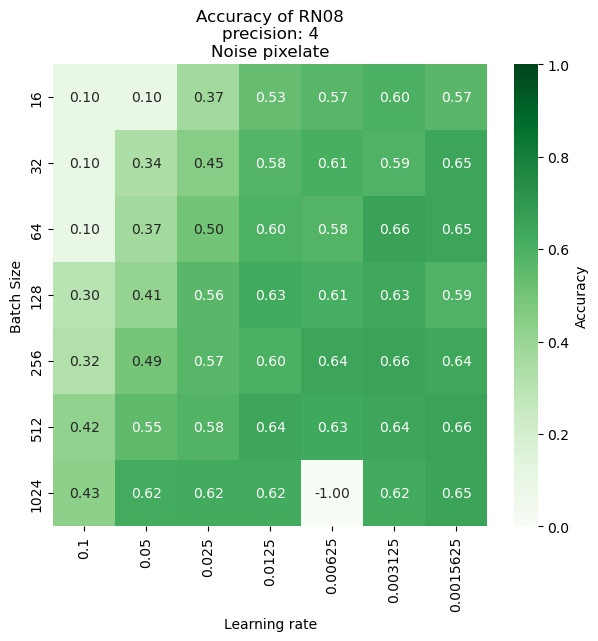

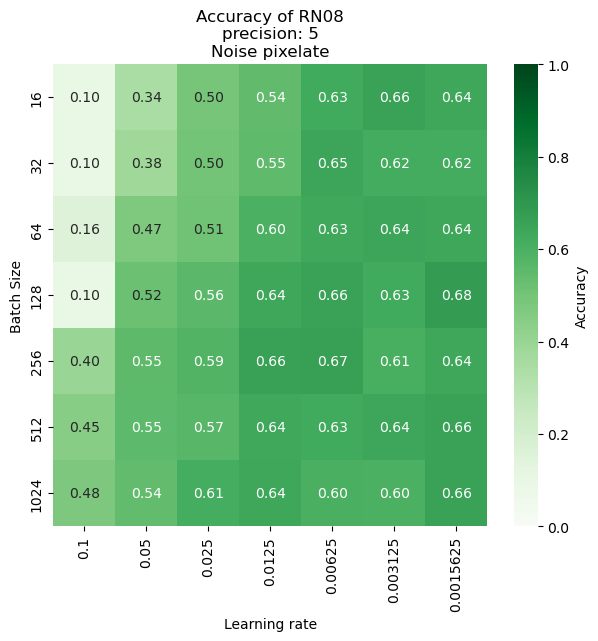

File not found! (/data/tbaldi/work/checkpoint/bs1024_lr0.00625/RN08_6b/accuracy_1.txt)
/data/tbaldi/work/checkpoint/bs1024_lr0.00625/RN08_6b/accuracy_pixelate.txt not found!


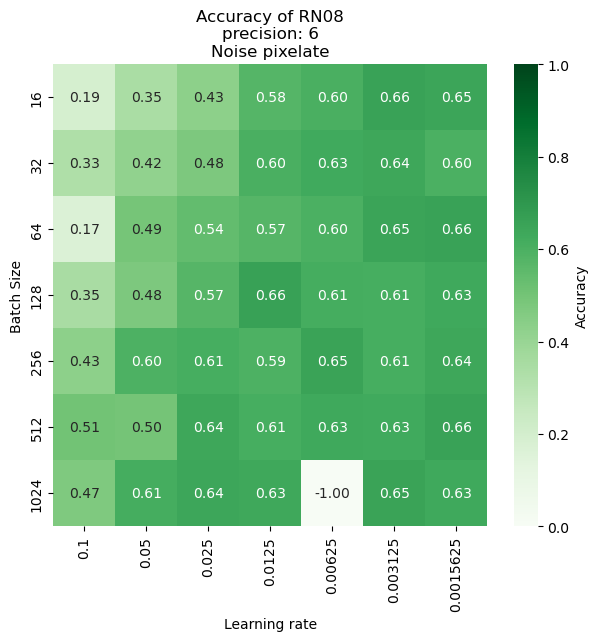

File not found! (/data/tbaldi/work/checkpoint/bs1024_lr0.00625/RN08_7b/accuracy_1.txt)
/data/tbaldi/work/checkpoint/bs1024_lr0.00625/RN08_7b/accuracy_pixelate.txt not found!


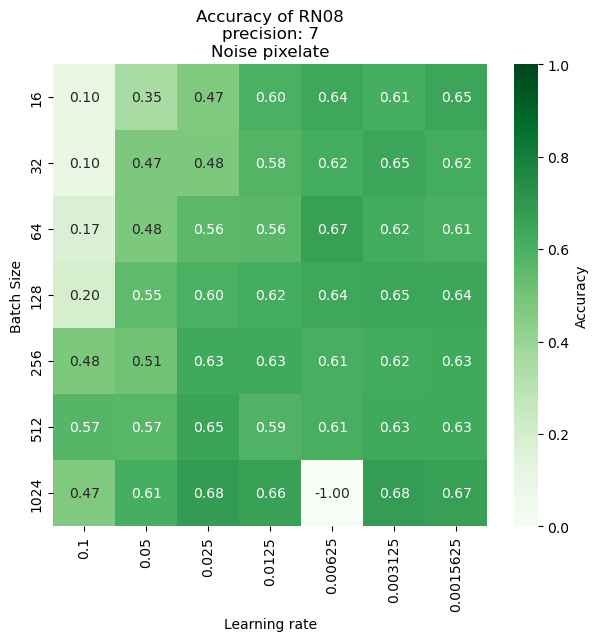

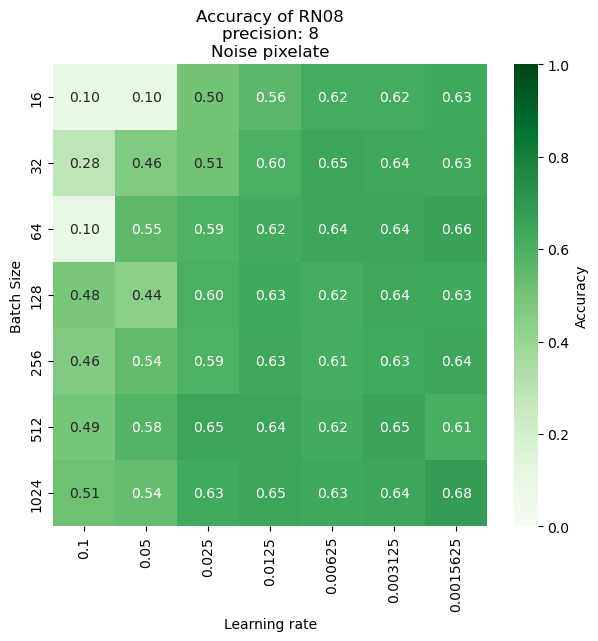

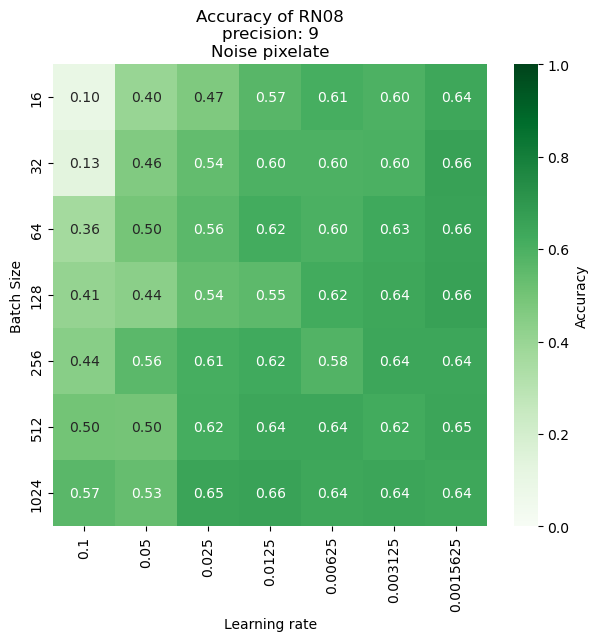

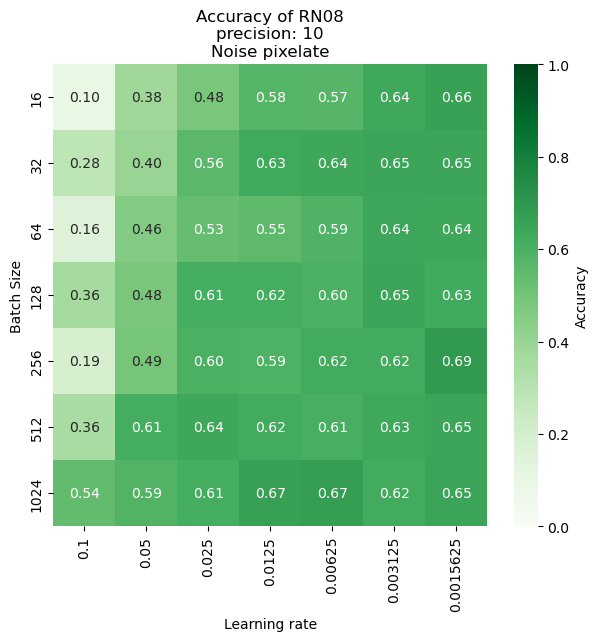

File not found! (/data/tbaldi/work/checkpoint/bs1024_lr0.00625/RN08_11b/accuracy_1.txt)
/data/tbaldi/work/checkpoint/bs1024_lr0.00625/RN08_11b/accuracy_pixelate.txt not found!


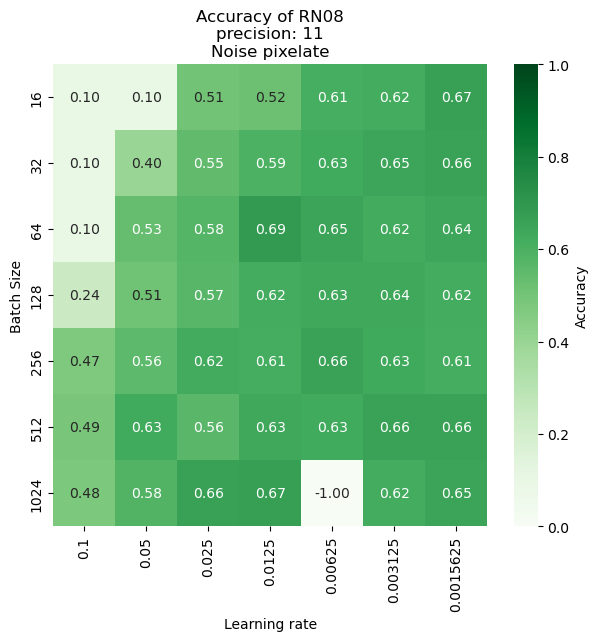

In [18]:
acc_distribution = []
for p in precisions:
    matrix = np.zeros((len(batch_sizes), len(learning_rates)))
    for x, bs in enumerate(batch_sizes):
        for y, lr in enumerate(learning_rates):
            acc = rn08.get_accuracy(DATA_PATH, bs, lr, p)
            noise_acc = rn08.get_accuracy_with_noise(DATA_PATH, bs, lr, p, noise_type)
            
            matrix[x, y] = noise_acc
            
            acc_distribution.append({
                'precision': p, 
                'accuracy': acc,
                'noise accuracy': noise_acc,
                'batch_size': str(bs),
                'learning_rate': str(lr),
                'precision': p,
            })
            
    matrix = pd.DataFrame(matrix,
                          index=batch_sizes,
                          columns=learning_rates)
    
    plot_2d_heatmap(matrix, 
                    f'Accuracy of RN08\nprecision: {p}\n' \
                    f'Noise {noise_type}', 
                    (0, 1),
                    'Learning rate',
                    'Batch Size',
                    'Accuracy',
                    cmap='Greens')

In [19]:
acc_distribution_df = pd.DataFrame(acc_distribution)
# export the CSV
acc_distribution_df.to_csv("./results/rn08/noise.csv", index=False)

--------------------------------------------------------------------------------


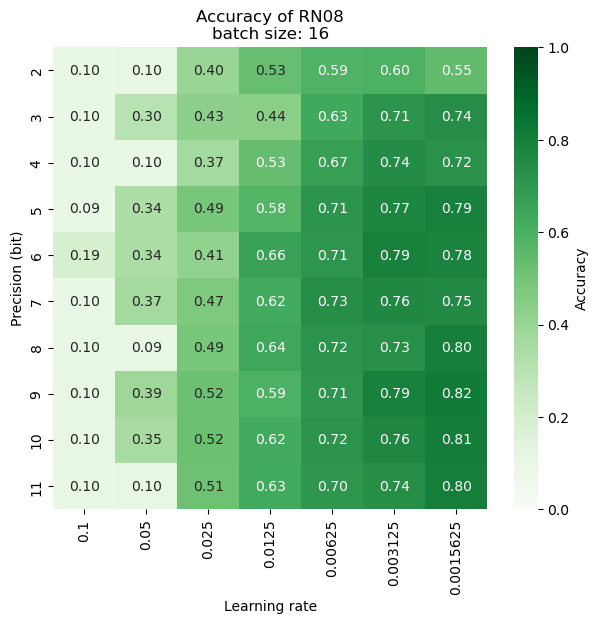

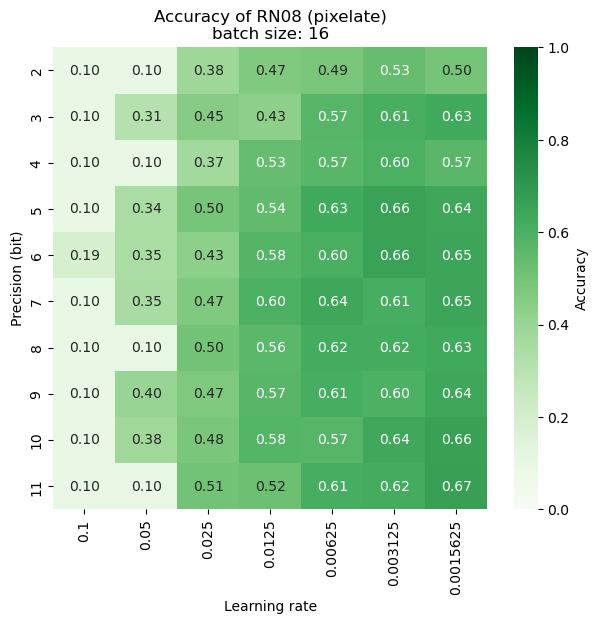

File not found! (/data/tbaldi/work/checkpoint/bs32_lr0.05/RN08_2b/accuracy_1.txt)
/data/tbaldi/work/checkpoint/bs32_lr0.05/RN08_2b/accuracy_pixelate.txt not found!
File not found! (/data/tbaldi/work/checkpoint/bs32_lr0.00625/RN08_2b/accuracy_1.txt)
/data/tbaldi/work/checkpoint/bs32_lr0.00625/RN08_2b/accuracy_pixelate.txt not found!
--------------------------------------------------------------------------------


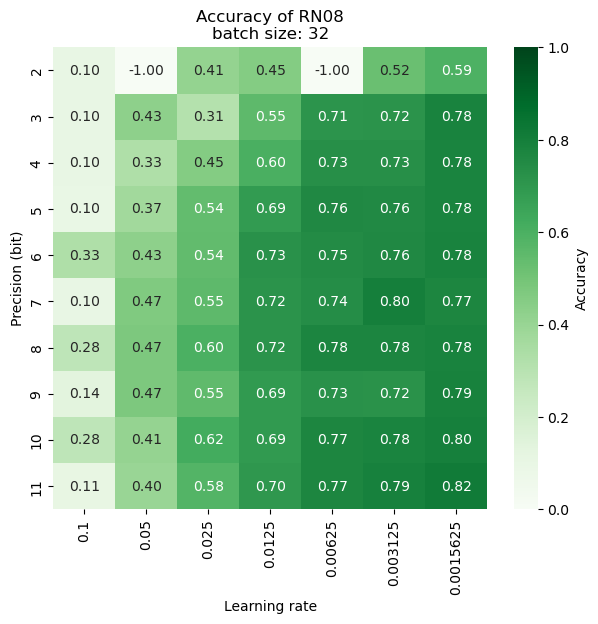

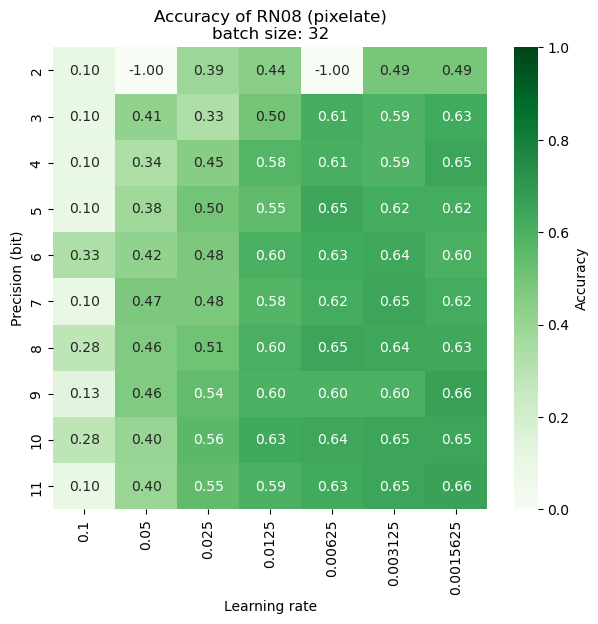

File not found! (/data/tbaldi/work/checkpoint/bs64_lr0.025/RN08_2b/accuracy_1.txt)
/data/tbaldi/work/checkpoint/bs64_lr0.025/RN08_2b/accuracy_pixelate.txt not found!
File not found! (/data/tbaldi/work/checkpoint/bs64_lr0.0125/RN08_2b/accuracy_1.txt)
/data/tbaldi/work/checkpoint/bs64_lr0.0125/RN08_2b/accuracy_pixelate.txt not found!
--------------------------------------------------------------------------------


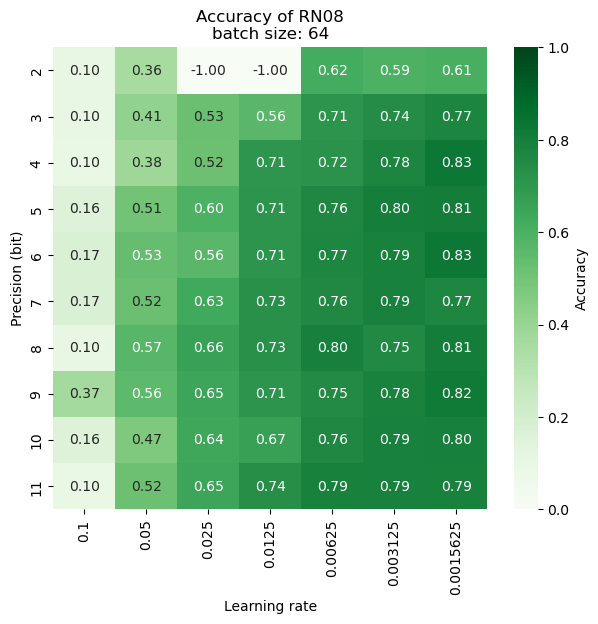

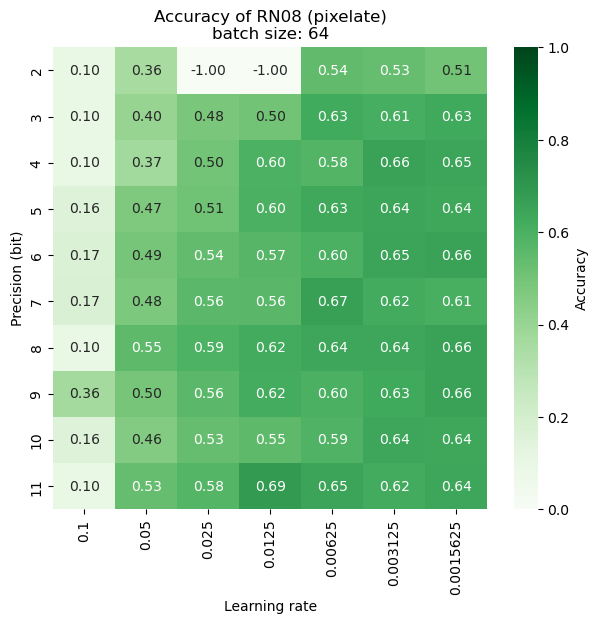

File not found! (/data/tbaldi/work/checkpoint/bs128_lr0.05/RN08_2b/accuracy_1.txt)
/data/tbaldi/work/checkpoint/bs128_lr0.05/RN08_2b/accuracy_pixelate.txt not found!
File not found! (/data/tbaldi/work/checkpoint/bs128_lr0.00625/RN08_2b/accuracy_1.txt)
/data/tbaldi/work/checkpoint/bs128_lr0.00625/RN08_2b/accuracy_pixelate.txt not found!
--------------------------------------------------------------------------------


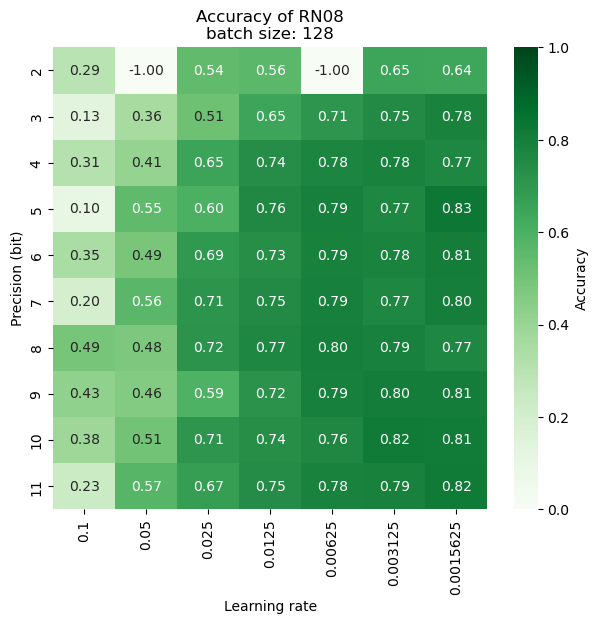

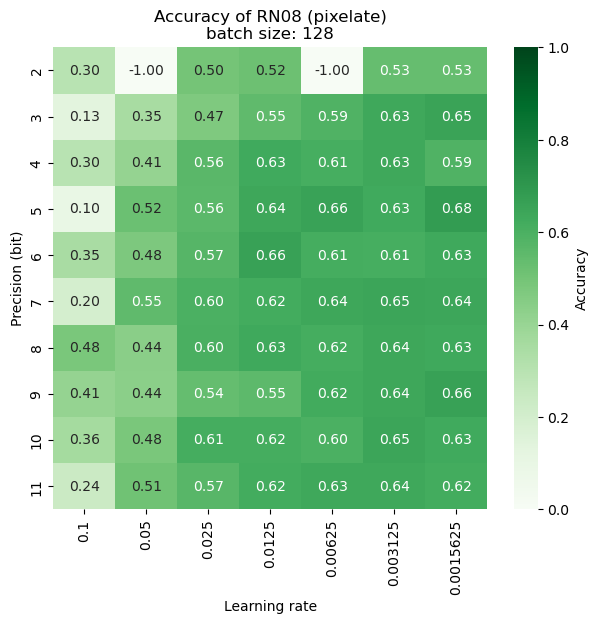

File not found! (/data/tbaldi/work/checkpoint/bs256_lr0.003125/RN08_2b/accuracy_1.txt)
/data/tbaldi/work/checkpoint/bs256_lr0.003125/RN08_2b/accuracy_pixelate.txt not found!
--------------------------------------------------------------------------------


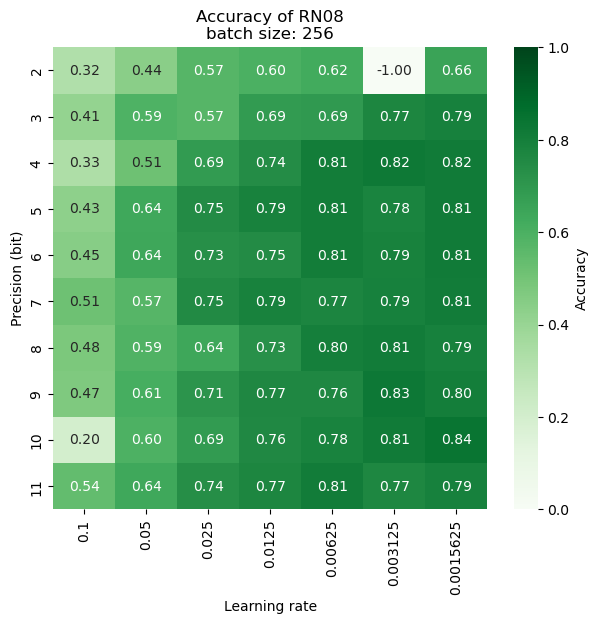

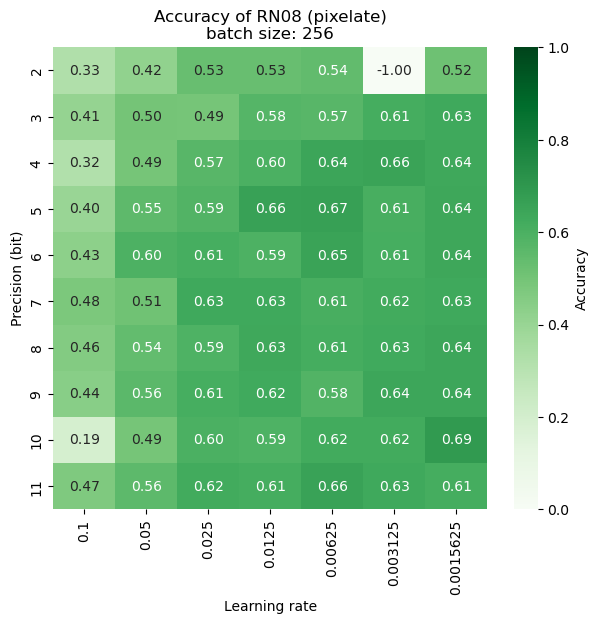

File not found! (/data/tbaldi/work/checkpoint/bs512_lr0.0015625/RN08_2b/accuracy_1.txt)
/data/tbaldi/work/checkpoint/bs512_lr0.0015625/RN08_2b/accuracy_pixelate.txt not found!
--------------------------------------------------------------------------------


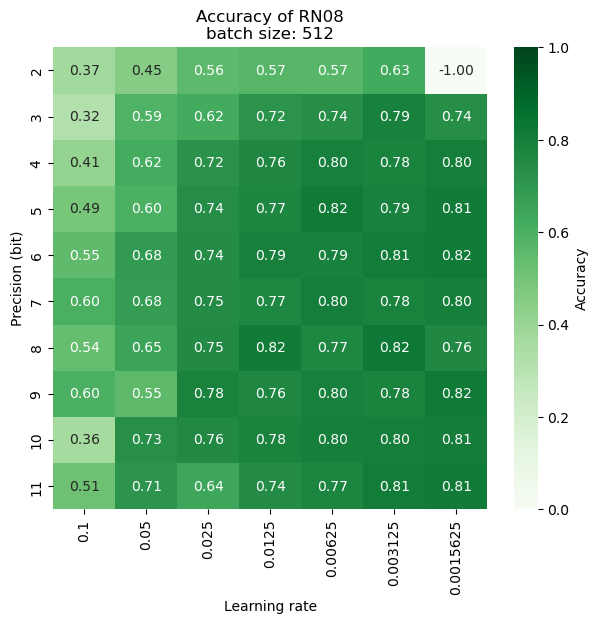

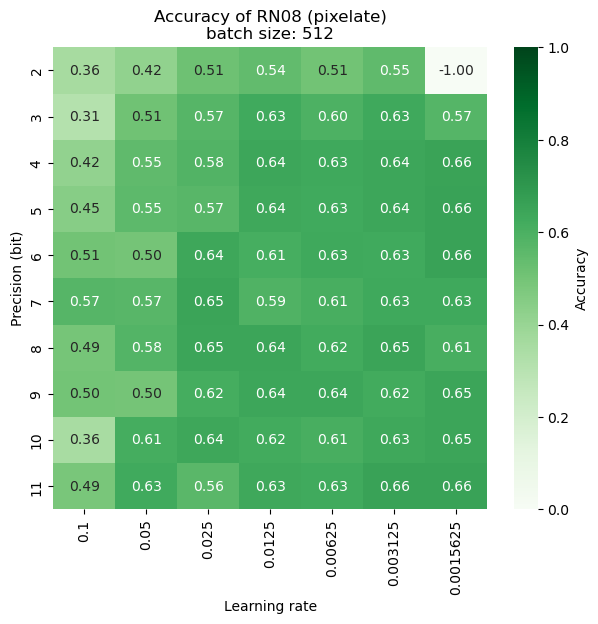

File not found! (/data/tbaldi/work/checkpoint/bs1024_lr0.00625/RN08_4b/accuracy_1.txt)
/data/tbaldi/work/checkpoint/bs1024_lr0.00625/RN08_4b/accuracy_pixelate.txt not found!
File not found! (/data/tbaldi/work/checkpoint/bs1024_lr0.00625/RN08_6b/accuracy_1.txt)
/data/tbaldi/work/checkpoint/bs1024_lr0.00625/RN08_6b/accuracy_pixelate.txt not found!
File not found! (/data/tbaldi/work/checkpoint/bs1024_lr0.00625/RN08_7b/accuracy_1.txt)
/data/tbaldi/work/checkpoint/bs1024_lr0.00625/RN08_7b/accuracy_pixelate.txt not found!
File not found! (/data/tbaldi/work/checkpoint/bs1024_lr0.00625/RN08_11b/accuracy_1.txt)
/data/tbaldi/work/checkpoint/bs1024_lr0.00625/RN08_11b/accuracy_pixelate.txt not found!
File not found! (/data/tbaldi/work/checkpoint/bs1024_lr0.003125/RN08_2b/accuracy_1.txt)
/data/tbaldi/work/checkpoint/bs1024_lr0.003125/RN08_2b/accuracy_pixelate.txt not found!
File not found! (/data/tbaldi/work/checkpoint/bs1024_lr0.0015625/RN08_2b/accuracy_1.txt)
/data/tbaldi/work/checkpoint/bs1024_l

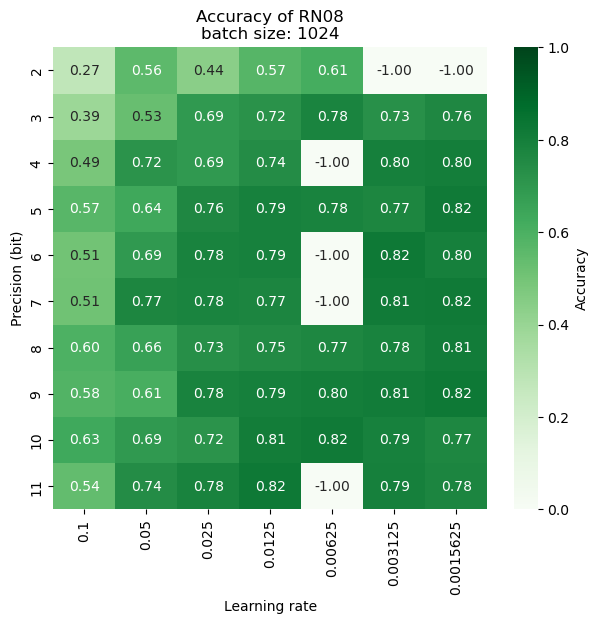

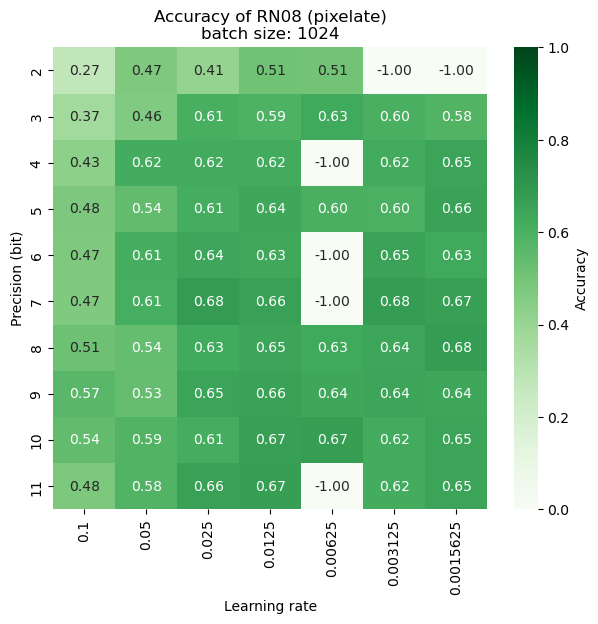

In [20]:

for bs in batch_sizes:
    matrix = np.zeros((len(precisions), len(learning_rates)))
    noise_matrix = np.zeros((len(precisions), len(learning_rates)))
    for y, lr in enumerate(learning_rates):
        for x, p in enumerate(precisions):
            
            # get the performances with and without noise
            acc = rn08.get_accuracy(DATA_PATH, bs, lr, p)
            noise_acc = rn08.get_accuracy_with_noise(DATA_PATH, bs, lr, p, noise_type)
            
            # build the heatmap matrix
            matrix[x, y] = acc
            noise_matrix[x, y] = noise_acc

            
    # plot the heatmaps per precision
    matrix = pd.DataFrame(matrix, 
                          index=precisions, 
                          columns=learning_rates)
    noise_matrix = pd.DataFrame(noise_matrix, 
                          index=precisions, 
                          columns=learning_rates)
    print(80*'-')
    plot_2d_heatmap(matrix, 
                    f'Accuracy of RN08\nbatch size: {bs}', 
                    (0, 1),
                    'Learning rate',
                    'Precision (bit)',
                    'Accuracy',
                    cmap='Greens')
    
    plot_2d_heatmap(noise_matrix, 
                    f'Accuracy of RN08 ({noise_type})\nbatch size: {bs}', 
                    (0, 1),
                    'Learning rate',
                    'Precision (bit)',
                    'Accuracy',
                    cmap='Greens')